In [2]:
# Extract ERP for each year (Estimated Residential Population)
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

erp_predicted = spark.read.csv("../../generic-real-estate-consulting-project-group-43/data/curated/feature_prediction/22_27_population.csv", header=True)

erp_predicted = erp_predicted.withColumn("pred",erp_predicted["pred"].cast(IntegerType()))

erp_predicted.printSchema()

# Victoria state data only
erp_agg = erp_predicted.groupBy('year').sum('pred').alias('pred')

erp_agg.withColumnRenamed("sum(pred)","pred")

plt.plot(erp_agg['year'],erp_agg['pred'])
plt.title('title name')
plt.xlabel('Year')
plt.ylabel('ERP Predicted')
plt.show()

22/09/26 15:57:54 WARN Utils: Your hostname, Hyunjin-Win11 resolves to a loopback address: 127.0.1.1; using 172.24.195.83 instead (on interface eth0)
22/09/26 15:57:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/26 15:57:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- _c0: string (nullable = true)
 |-- year: string (nullable = true)
 |-- SA2 code: string (nullable = true)
 |-- pred: integer (nullable = true)



AnalysisException: Cannot resolve column name "pred" among (year, sum(pred))

22/09/26 15:24:33 WARN Utils: Your hostname, Hyunjin-Win11 resolves to a loopback address: 127.0.1.1; using 172.24.195.83 instead (on interface eth0)
22/09/26 15:24:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/26 15:24:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- sa2_name_2016: string (nullable = true)
 |-- sa2_maincode_2016: string (nullable = true)
 |-- erp_2013: integer (nullable = true)
 |-- erp_2014: integer (nullable = true)
 |-- erp_2015: integer (nullable = true)
 |-- erp_2016: integer (nullable = true)
 |-- erp_2017: integer (nullable = true)
 |-- erp_2018: integer (nullable = true)
 |-- erp_2019: integer (nullable = true)
 |-- erp_2020: integer (nullable = true)
 |-- erp_2021: integer (nullable = true)



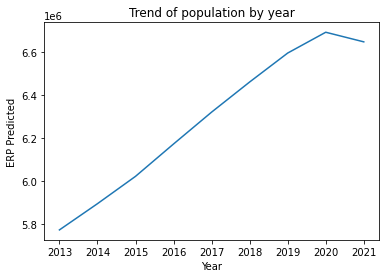

In [1]:
# Extract ERP for each year (Estimated Residential Population)
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt

erp_predicted = spark.read.csv("../../generic-real-estate-consulting-project-group-43/data/curated/erp_vic.csv", header=True)

erp_predicted = erp_predicted.withColumn("erp_2013",erp_predicted["erp_2013"].cast(IntegerType()))\
                                .withColumn("erp_2014",erp_predicted["erp_2014"].cast(IntegerType()))\
                                .withColumn("erp_2015",erp_predicted["erp_2015"].cast(IntegerType()))\
                                .withColumn("erp_2016",erp_predicted["erp_2016"].cast(IntegerType()))\
                                .withColumn("erp_2017",erp_predicted["erp_2017"].cast(IntegerType()))\
                                .withColumn("erp_2018",erp_predicted["erp_2018"].cast(IntegerType()))\
                                .withColumn("erp_2019",erp_predicted["erp_2019"].cast(IntegerType()))\
                                .withColumn("erp_2020",erp_predicted["erp_2020"].cast(IntegerType()))\
                                .withColumn("erp_2021",erp_predicted["erp_2021"].cast(IntegerType()))

erp_predicted.printSchema()

# Graph the erp trend line to decide how to predict erp from 2022 - 2027
erp_agg = erp_predicted.groupby().sum().toPandas()

year = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

y_axis = erp_agg.iloc[0]

plt.plot(year,y_axis)
plt.title('Trend of population by year')
plt.xlabel('Year')
plt.ylabel('ERP Predicted')
plt.show()

In [90]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd

# Define external predictors
external_preds = ['sa2_2021', 'min_distance_to_cbd','min_distance_to_park', 'min_distance_to_prim', 'min_distance_to_second'\
    , 'min_distance_to_train', 'min_distance_to_hosp', 'min_distance_to_poli', 'min_distance_to_shop', 'gdp', 'saving_rate', 'income_per_person',\
        'crime_cases', 'population_density']

# Define internal predictors
internal_preds = ['residence_type', 'nbed', 'nbath', 'ncar']

# OLS regression function for Data analysis
def ols_regression(merged_df):
    # OLS Regression
    # External ----------------------------------------------------------------------------------------------------
    external_model = ols(formula = 'weekly_rent ~ C(sa2_2021) + min_distance_to_cbd + \
        min_distance_to_park + min_distance_to_prim + min_distance_to_second + min_distance_to_train +\
        min_distance_to_hosp + min_distance_to_poli + min_distance_to_shop + gdp + saving_rate + income_per_person +\
        crime_cases + population_density', data = merged_df).fit()

    # Summary of external factors
    ex_summary = external_model.summary()

    print("Summary of external factors: ")
    print(ex_summary)

    # Anova table of external factors
    ex_anova_table = sm.stats.anova_lm(external_model, typ=2)

    print("Anova table of external factors: ")
    print(ex_anova_table)

    # Extract p-values for the predictors
    ex_pvals = external_model.pvalues[:]

    # Internal ----------------------------------------------------------------------------------------------------
    internal_model = ols(formula = 'weekly_rent ~ residence_type + nbed + nbath + ncar', data = merged_df).fit()

    # Summary of internal factors
    in_summary = internal_model.summary()

    print("Summary of internal factors: ")
    print(in_summary)

    # Anova table of internal factors
    in_anova_table = sm.stats.anova_lm(internal_model, typ=2)

    print("Anova table of internal factors: ")
    print(in_anova_table)

    # Extract p-values for the predictors
    in_pvals = internal_model.pvalues[:]

    return ex_pvals, in_pvals

# csv file function
def put_signigicants_csv(external_preds, ex_pvalues, internal_preds, in_pvalues, new_csv):
    print(ex_pvalues, in_pvalues)
    sign_ex_predictors = [external_preds[(pre-1)]  for pre in range(1, len(ex_pvalues)) if ex_pvalues[pre] < 0.05]

    sign_in_predictors = [internal_preds[(pre-1)] for pre in range(1, len(in_pvalues)) if in_pvalues[pre] < 0.05]
    
    external_df = pd.DataFrame({'Significant External predictors': sign_ex_predictors})
    internal_df = pd.DataFrame({'Significant Internal predictors': sign_in_predictors})
    new = pd.concat([external_df, internal_df], axis=1) 

    print(new_csv)
    new.to_csv(new_csv)

In [96]:
# Make a new folder for significant variable csv files
import os
  
# Directory
directory = "significant"
  
# Parent Directory path
parent_dir = "../data/curated/"

# Path
path = os.path.join(parent_dir, directory)

# Create the directory
os.mkdir(path)

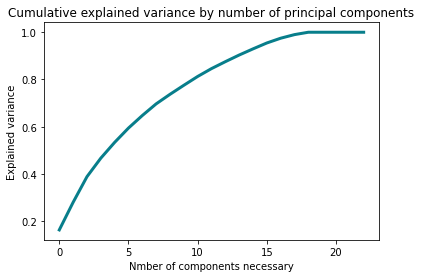

In [93]:
# Scrutinize the data with PCA: Test the attribute relevance
from heapq import merge
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

merged_df = spark.read.csv("../data/curated/merged_dataset/2013_merged_data.csv", header=True)
for c in merged_df.columns:
    if (c not in  ['address', 'residence_type']):
        merged_df = merged_df.withColumn(c,merged_df[c].cast(IntegerType())) 

merged_df = merged_df.toPandas()

merged_df['residence_type'] = merged_df['residence_type'].astype('category')
merged_df['residence_type'] = merged_df['residence_type'].cat.codes

merged_df.iloc[:, 13:21] = merged_df.iloc[:, 13:21].replace(np.nan, 99999)

merged_df = merged_df.dropna()

X = merged_df.drop(['address', 'weekly_rent'], axis=1)
y = merged_df['weekly_rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

pca = PCA().fit(X_train_scaled)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components')
plt.xlabel("Nmber of components necessary")
plt.ylabel("Explained variance")
plt.show()

In [97]:
# Scrutinize the data with PCA: Test the attribute relevance for only 2013 (For testing)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from csv import writer
import pandas as pd

merged_df.rename(columns = {'gdp(USD Millioins)':'gdp', 'saving_rate(% of GDP)':'saving_rate'}, inplace = True)

ex_pvalues, in_pvalues = ols_regression(merged_df)

Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     191.1
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:43:41   Log-Likelihood:                -48672.
No. Observations:                7726   AIC:                         9.737e+04
Df Residuals:                    7713   BIC:                         9.746e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [98]:
# Implement for every file to see annual trend
import os

parent_dir = "../data/curated/merged_dataset"

for filename in os.listdir(parent_dir):
    print(filename, "----------------------------------------------------------------------------------------------------------------")
    merged_df_yr = spark.read.csv(parent_dir + "/" + filename, header=True)
    for c in merged_df_yr.columns:
        if (c not in  ['address', 'residence_type']):
            merged_df_yr = merged_df_yr.withColumn(c,merged_df_yr[c].cast(IntegerType())) 

    merged_df_yr = merged_df_yr.toPandas()

    merged_df_yr['residence_type'] = merged_df_yr['residence_type'].astype('category')
    merged_df_yr['residence_type'] = merged_df_yr['residence_type'].cat.codes

    merged_df_yr.iloc[:, 13:21] = merged_df_yr.iloc[:, 13:21].replace(np.nan, 99999)

    merged_df_yr = merged_df_yr.dropna()

    merged_df_yr.rename(columns = {'gdp(USD Millioins)':'gdp', 'saving_rate(% of GDP)':'saving_rate'}, inplace = True)

    # Implement ols regression to analyze the data
    ex_pvalues, in_pvalues = ols_regression(merged_df_yr)
    
    new_csv_name = "../data/curated/significant/" + filename

    put_signigicants_csv(external_preds, ex_pvalues, internal_preds, in_pvalues, new_csv_name)

2013_merged_data.csv ----------------------------------------------------------------------------------------------------------------


Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     208.8
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:44:03   Log-Likelihood:                -53807.
No. Observations:                8566   AIC:                         1.076e+05
Df Residuals:                    8553   BIC:                         1.077e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     166.5
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:44:09   Log-Likelihood:            -1.3250e+05
No. Observations:               19369   AIC:                         2.650e+05
Df Residuals:                   19356   BIC:                         2.651e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     453.3
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:44:21   Log-Likelihood:            -3.6624e+05
No. Observations:               53696   AIC:                         7.325e+05
Df Residuals:                   53683   BIC:                         7.326e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     431.7
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:44:26   Log-Likelihood:                -90293.
No. Observations:               14206   AIC:                         1.806e+05
Df Residuals:                   14193   BIC:                         1.807e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     340.1
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:44:46   Log-Likelihood:                -83086.
No. Observations:               12973   AIC:                         1.662e+05
Df Residuals:                   12960   BIC:                         1.663e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     342.2
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:44:50   Log-Likelihood:                -63523.
No. Observations:               10245   AIC:                         1.271e+05
Df Residuals:                   10232   BIC:                         1.272e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Summary of external factors: 
                            OLS Regression Results                            
Dep. Variable:            weekly_rent   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     451.3
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:44:54   Log-Likelihood:            -1.0270e+05
No. Observations:               16029   AIC:                         2.054e+05
Df Residuals:                   16016   BIC:                         2.055e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

22/09/29 19:22:46 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 131767 ms exceeds timeout 120000 ms
22/09/29 19:22:47 WARN SparkContext: Killing executors is not supported by current scheduler.
